# 프로젝트: 뉴스기사 요약해보기
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기 (추상적 요약)
- Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- Step 5. Summa을 이용해서 추출적 요약해보기

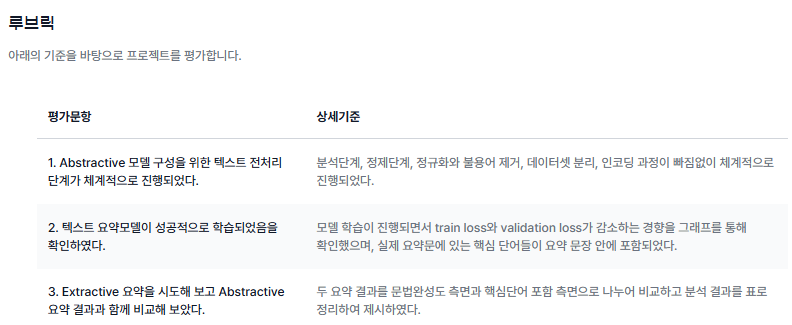

## Step 1. 데이터 수집하기

In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')

import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
3090,Shubman Gill can represent India for a long ti...,Speaking about his teammate from Punjab's Ranj...
77552,Govt may retain Air India's national carrier s...,Finance Minister Arun Jaitley has said that go...
53594,Citigroup fined over flaws in money laundering...,A US regulator has imposed a penalty of $70 mi...
7977,"UP CM Yogi gets air, water security cover amid...",Uttar Pradesh Chief Minister Yogi Adityanath i...
15401,Ranbir receives Barca jersey signed by Messi o...,Bollywood actor Ranbir Kapoor received an FC B...
66461,I was verbally abused by Uber driver: Comedian...,Actor-comedian Mallika Dua took to social medi...
78973,Mithali Raj named captain of ICC Women's World...,"Mithali Raj, who led India to their second Wom..."
13607,US will 'punish' itself if it halts Saudi arms...,"President Donald Trump has said US would ""puni..."
73214,Pak acquits Benazir Bhutto's husband in 19-yr-...,A Pakistani court on Saturday acquitted former...
27918,"Number of terms for PMs, CMs should be fixed: ...",Congress MP Jyotiraditya Scindia on Saturday s...


TEXT와 HEADLINE 두가지 열로 구성.
- 추상적 요약 -> TEXT본문, HEADLINE을 이미 요약된 데이터로 삼아 모델 학습
- 추출적 요약 -> 오직 TEXT열만 사용

## Step 2. 데이터 전처리하기 (추상적 요약)

In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
# 데이터 Null값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (head)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# 불용어 전처리 결과 확인
temp_headlines = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_text = 'Great way to start (or finish) the day!!!'

print("headlines: ", preprocess_sentence(temp_headlines, False))
print("text:", preprocess_sentence(temp_text))

headlines:  everything bought was great infact ordered twice and the third ordered wasfor my mother and father
text: great way start day


text 경우 불용어 제거, headlines 경우 불용어 제거X, 따로 호출해 진행

In [11]:
# 전체 headlines 데이터에 대한 전처리
clean_head = []

for h in data["headlines"]:
    clean_head.append(preprocess_sentence(h, False))


# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_head[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for t in data["text"]:
    clean_text.append(preprocess_sentence(t))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
# 빈 샘플 확인 후 null 대체
data['headlines'] = clean_head
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299651426306644


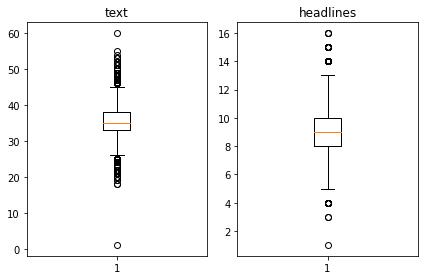

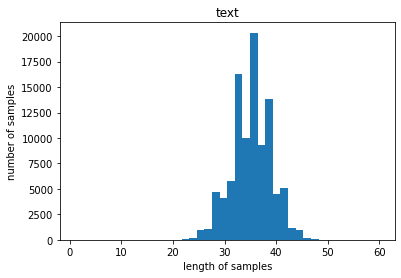

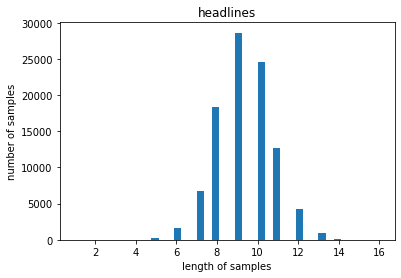

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
head_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(head_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(head_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(head_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

확인해보니 text는 대부분 40이하의 길이를 가지고 있음, headlines는 10이하의 길이를 가지고 있다.

In [21]:
# 적절한 길이 정하기
text_max_len = 40
head_max_len = 10

In [22]:
# 샘플의 길이 입력 -> 데이터의 몇 %가 해당하는지 계산
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [73]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(head_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 1.0


In [24]:
# 정해진 길이보다 길면 제외하는 방법으로 정제하기
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & 
            data['headlines'].apply(lambda x: len(x.split()) <= head_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74128


### 시작 토큰과 종료 토큰 추가하기
- 시작토큰(SOS)
- 종료토큰(EOS)

In [25]:
# headline 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sos'+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + 'eos')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sosnew zealand end rohit sharma led india matc...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sosaegon life iterm insurance plan helps custo...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sosrahat fateh ali khan denies getting notice ...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,soscong wins ramgarh bypoll in rajasthan takes...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sosup cousins fed human excreta for friendship...,up cousins fed human excreta for friendship wi...


In [26]:
# token Numpy 타입 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [27]:
# 훈련/테스트 데이터 분리 - 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
# 8:2 비율로 훈련/테스트 데이터 분리(전체 데이터 크기 x 0.2)
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14825


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59303
훈련 레이블의 개수 : 59303
테스트 데이터의 개수 : 14825
테스트 레이블의 개수 : 14825


### 단어집합(vocabulary) 만들기 및 정수 인코딩
각 단어에 고유한 정수를 맵핑하는 작업

In [31]:
# 토크나이저 사용하여 입력된 훈련 데이터로부터 단어 집합 생성
src_tok = Tokenizer() # 토크나이저 정의
src_tok.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- 현재 생성된 단어 집합은 `src_tokenizer.word_index` 에 저장
- `src_tokenizer.word_counts.items()` 에는 단어와 각 단어의 등장 빈도수가 저장

In [32]:
threshold = 7
total_cnt = len(src_tok.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tok.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61632
등장 빈도가 6번 이하인 희귀 단어의 수: 42262
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19370
단어 집합에서 희귀 단어의 비율: 68.57152128764278
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.183162485666501


In [35]:
# 단어 집합크기(희귀제외): 19000 제한
src_vocab = 19000
src_tok = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tok.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [36]:
# 19,000 넘는 숫자들은 정수 인코딩 후 데이터에 존재하지 않게됨
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tok.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tok.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[112, 428, 411, 224, 86, 813, 575, 426, 3, 234, 292, 141, 4414, 373, 426, 602, 313, 23, 33, 292, 141, 779, 86, 373, 426, 813, 86, 602], [495, 2109, 1081, 78, 740, 310, 1884, 99, 417, 2, 42, 470, 78, 233, 380, 470, 5898, 228, 197, 48, 651, 56, 558, 531, 780, 33, 78, 1454, 1897, 1, 3, 15], [714, 438, 50, 409, 471, 1655, 4415, 167, 140, 389, 760, 517, 140, 4066, 185, 389, 3528, 1689, 389, 33, 10621, 367, 209, 197, 389, 2995, 575, 4448, 12141, 585]]


In [38]:
# headlines 데이터에도 동일한 작업 수행
tar_tok = Tokenizer()
tar_tok.fit_on_texts(decoder_input_train)

In [40]:
threshold = 6
total_cnt = len(tar_tok.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tok.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 34574
등장 빈도가 5번 이하인 희귀 단어의 수: 24513
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 10061
단어 집합에서 희귀 단어의 비율: 70.9000983397929
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.737088986676445


In [41]:
# 단어 집합 크기(희귀제외): 10000
tar_vocab = 10000
tar_tok = Tokenizer(num_words=tar_vocab) 
tar_tok.fit_on_texts(decoder_input_train)
tar_tok.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tok.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tok.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tok.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tok.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[4821, 50, 2, 793, 2376, 249, 2, 60], [944, 997, 341, 873, 11, 53, 7, 232], [7194, 778, 260, 329, 4085, 5834, 3, 291, 262], [7195, 4497, 1463, 72, 148, 169, 2], [420, 182, 1200, 1, 127, 4822, 9, 536, 230]]
target
decoder  [[706, 50, 2, 793, 2376, 249, 2, 345], [944, 997, 341, 873, 11, 53, 7, 2632], [1491, 778, 260, 329, 4085, 5834, 3, 291, 3609], [7155, 7195, 4497, 1463, 72, 148, 169, 245], [78, 182, 1200, 1, 127, 4822, 9, 536, 4081]]


- 문제: 빈도수 낮은 단어가 삭제? -> 빈 샘플이 되었을 가능성이 있다.
    - 헤드라인(`decoder_input`)에는 `sos` 토큰 또는 `decoder_target`에는 `eos` 추가된 상태
    - 두 토큰은 모든 샘플에 등장, 빈도수가 샘플 수와 동일하게 높다.
    - 길이 0 헤드라인 -> 실제 길이 1
    헤드라인 길이가 1인 경우, `drop` 변수에 저장해 샘플 삭제

In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 3
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 59300
훈련 레이블의 개수 : 59300
테스트 데이터의 개수 : 14823
테스트 레이블의 개수 : 14823


### 패딩하기
텍스트 시퀀스 -> 정수 시퀀스: 서로 다른 길이의 샘플 처리를 같은 길이로 맞춰줘야함

In [43]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)


### 모델 설계하기
인코더 LSTM 1 참고, 나머지 LSTM2, LSTM3 코드 완성

In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)

LSTM 의 dropout 방식은 사진 참고
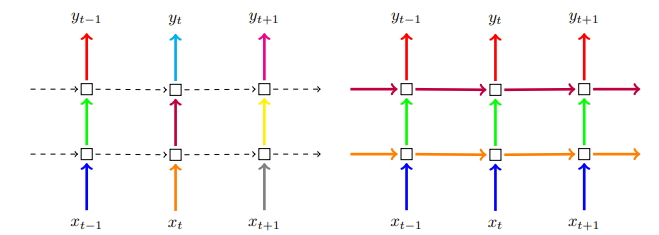

In [46]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM 1: 인코더의 state_h1, state_c1을 초기 상태로 사용
decoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs1, dec_state_h1, dec_state_c1 = decoder_lstm1(dec_emb, initial_state=[state_h1, state_c1])

# 디코더의 LSTM 2: LSTM 1의 출력(decoder_outputs1)을 입력으로 사용하고, 인코더의 state_h2, state_c2를 초기 상태로 사용
decoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs2, dec_state_h2, dec_state_c2 = decoder_lstm2(decoder_outputs1, initial_state=[state_h2, state_c2])

# 디코더의 LSTM 3: LSTM 2의 출력(decoder_outputs2)을 입력으로 사용하고, 인코더의 state_h3, state_c3를 초기 상태로 사용
decoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs3, dec_state_h3, dec_state_c3 = decoder_lstm3(decoder_outputs2, initial_state=[state_h3, state_c3])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일.
- LSTM 입력 <<= 인코더의 hidden state와 cell state 값

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs3) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      2432000     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    1280000     input_3[0][0]                    
______________________________________________________________________________________________

정리! 지금 설계한 것은 `인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq`

### 어텐션 메커니즘
시퀀스투시퀀스 모델 <- 어텐션 메커니즘 적용!

In [48]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs3, encoder_outputs3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs3, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      2432000     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    1280000     input_3[0][0]                    
____________________________________________________________________________________________

### 모델 훈련하기

In [49]:
# 설계한 모델 가지고 훈련 진행
# Early Stopping 적용: 특정 조건이 충족되면 훈련이 멈춤. 모델훈련 최적점 찾기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 59s 198ms/step - loss: 5.9990 - val_loss: 5.2939
Epoch 2/50
232/232 [==============================] - 43s 186ms/step - loss: 5.0093 - val_loss: 4.6101
Epoch 3/50
232/232 [==============================] - 44s 189ms/step - loss: 4.4911 - val_loss: 4.1848
Epoch 4/50
232/232 [==============================] - 43s 187ms/step - loss: 4.1063 - val_loss: 3.8919
Epoch 5/50
232/232 [==============================] - 43s 185ms/step - loss: 3.8092 - val_loss: 3.6700
Epoch 6/50
232/232 [==============================] - 44s 188ms/step - loss: 3.5643 - val_loss: 3.5016
Epoch 7/50
232/232 [==============================] - 44s 188ms/step - loss: 3.3632 - val_loss: 3.3543
Epoch 8/50
232/232 [==============================] - 43s 187ms/step - loss: 3.1682 - val_loss: 3.2062
Epoch 9/50
232/232 [==============================] - 44s 188ms/step - loss: 2.9914 - val_loss: 3.0891
Epoch 10/50
232/232 [==============================] - 44s 188ms/step - l

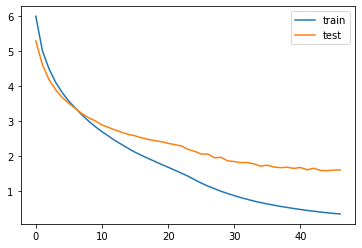

In [50]:
# 훈련/검증 데이터 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기
테스트 단계(인덱스 행렬) -> 텍스트 데이터 실제 데이터 복원

In [51]:
src_index_to_word = src_tok.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tok.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tok.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [54]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs1, state_h1, state_c1])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs1, state_h1, state_c1 = decoder_lstm1(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


- Q. 정답 문장이 없는 인퍼런스 단계에서는 왜 문장의 길이만큼 디코더가 반복구조로 동작해야 하나요?(모델 설계 별도)
- A. 정답 문장이 없다면 다음 단계에서 미리 예측하기 위해 초기상태를 이전 시점 상태로 적용해야 해서

### 어켄션 메커니즘 사용 출력층 설계!

In [55]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))  # 인코더 전체 출력
attn_layer = AdditiveAttention(name='attention_layer')
attn_out_inf = attn_layer([decoder_outputs1, decoder_hidden_state_input])

# 어텐션 출력과 디코더 출력 결합
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs1, attn_out_inf])

# 디코더의 출력층 (소프트맥스 출력)
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_softmax_outputs, state_h1, state_c1]
)

print('모델 설계 완료')

모델 설계 완료


### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [70]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decodera_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트하기
- seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2head 함수

In [74]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2head(input_seq):
    temp=''
    for i in input_seq:
        if (i == src_index_to_word.get('sos') and i == src_index_to_word.get('eos')):
            continue
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp.strip()

In [75]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2head(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : day cag released report criticising food served stations trains ministry railways said indian railway catering tourism corporation formed new catering policy cag termed food stations trains unfit human consumption said packaged items served expiry dates 
실제 요약 : gambhir earlier japanese said sessions caught amid northern


KeyError: 'sos'

## Step 5. Summa을 이용해서 추출적 요약해보기

In [76]:
import requests
from summa.summarizer import summarize

In [77]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [78]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [79]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [80]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
